# <font color=green>Recurrent Neural Networks for H1 Time frame</font>

# <font color=green>Import Libraries</font>

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# <font color=green>H1 Timeframe</font>

In [2]:
# read in H1 timeframe price data
df_h1_feature = pd.read_csv('../data/df_h1_feature.csv', index_col=0)
df_h1_feature.index = pd.to_datetime(df_h1_feature.index)
df_h1_feature = df_h1_feature.dropna()
df_h1_feature.head()

,open,high,low,close,results,hr_of_day,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-01-07 12:00:00,1.0424,1.0428,1.0408,1.0410,2,12,1,1.0423,-1.3,1.0436,-2.6,1.0435,-2.5,1.0429,-1.9,1.0410,0.0,1.0440,-3.0,1.0472,-6.2,1.0434,-2.4,1.0393,1.7,1.0485,-7.5,1.3,-0.1,1.2,-0.6,-0.7,0.6,-1.9,-2.5,-2.6,-1.3,3.0,1.1,0.5,0.4,1.7,3.2,6.2,4.3,3.7,3.6,4.9,-3.8,-0.6,2.4,0.5,-0.1,-0.2,1.1,-4.1,-7.9,-4.7,-1.7,-3.6,-4.2,-4.3,-3.0,9.2,5.1,1.3,4.5,7.5,5.6,5.0,4.9,6.2,1.04165,-0.65,1.042300,-1.300000,1.04240,-1.40,1.042125,-1.1250,1.042446,-1.446154,1.043314,-2.314286,1.044912,-3.911765,1.043765,-2.765455,1.042664,-1.664045,0.650000,0.100000,0.75,-0.2750,-0.175000,0.4750,0.321154,0.046154,0.146154,0.796154,0.868132,1.189286,0.914286,1.014286,1.664286,1.597479,2.465611,2.786765,2.511765,2.611765,3.261765,-1.146310,0.451169,1.319301,1.640455,1.365455,1.465455,2.115455,-1.101410,-2.247720,-0.650241,0.217891,0.539045,0.264045,0.364045,1.014045,-0.0013,0.0000,0.0013,37.068837,44.550170,7.481333,53.994513,16.925676,53.335001,16.266164,47.645725,10.576888,24.216833,-12.852004,33.875985,-3.192852,54.632562,17.563725,9.444343,-0.659512,8.784831,-5.689276,-6.348788,3.095555,-23.428892,-29.118168,-29.777680,-20.333337,9.659152,-13.769740,-19.459016,-20.118528,-10.674185,20.756576,30.415729,6.986837,1.297560,0.638049,10.082392,40.809503,45.204507,45.572811,40.950133,38.286167,37.541264,4.395003,0.368304,4.763308,-4.622678,-4.254374,0.140630,-2.663966,-7.286644,-6.918340,-2.523337,-0.744902,-3.408869,-8.031547,-7.663242,-3.268239
2003-01-07 13:00:00,1.0409,1.0425,1.0408,1.0413,2,13,1,1.0410,0.3,1.0423,-1

In [3]:
df_h1_feature.shape

(105518, 186)

In [4]:
df_h1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105518 entries, 2003-01-07 12:00:00 to 2019-12-30 16:00:00
Columns: 186 entries, open to rsi_14_sma_21m02
dtypes: float64(183), int64(3)
memory usage: 150.5 MB


In [5]:
# define features and multi-class results for modelling
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_h1_feature.columns if col not in non_feature]

X = df_h1_feature[features]
y = df_h1_feature['results']

## <font color=green>Train Test Split</font>

In [6]:
# shuffle=False for unrandomized time-series modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False )

In [7]:
X_train.head()

,hr_of_day,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-01-07 12:00:00,12,1,-1.3,-2.6,-2.5,-1.9,0.0,-3.0,-6.2,-2.4,1.7,1.0485,-7.5,1.3,-0.1,1.2,-0.6,-0.7,0.6,-1.9,-2.5,-2.6,-1.3,3.0,1.1,0.5,0.4,1.7,3.2,6.2,4.3,3.7,3.6,4.9,-3.8,-0.6,2.4,0.5,-0.1,-0.2,1.1,-4.1,-7.9,-4.7,-1.7,-3.6,-4.2,-4.3,-3.0,9.2,5.1,1.3,4.5,7.5,5.6,5.0,4.9,6.2,1.04165,-0.65,-1.300000,-1.40,-1.1250,-1.446154,-2.314286,-3.911765,-2.765455,-1.664045,0.650000,0.100000,0.75,-0.2750,-0.175000,0.4750,0.321154,0.046154,0.146154,0.796154,0.868132,1.189286,0.914286,1.014286,1.664286,1.597479,2.465611,2.786765,2.511765,2.611765,3.261765,-1.146310,0.451169,1.319301,1.640455,1.365455,1.465455,2.115455,-1.101410,-2.247720,-0.650241,0.217891,0.539045,0.264045,0.364045,1.014045,37.068837,44.550170,7.481333,53.994513,16.925676,53.335001,16.266164,47.645725,10.576888,24.216833,-12.852004,33.875985,-3.192852,54.632562,17.563725,9.444343,-0.659512,8.784831,-5.689276,-6.348788,3.095555,-23.428892,-29.118168,-29.777680,-20.333337,9.659152,-13.769740,-19.459016,-20.118528,-10.674185,20.756576,30.415729,6.986837,1.297560,0.638049,10.082392,40.809503,45.204507,45.572811,40.950133,38.286167,37.541264,4.395003,0.368304,4.763308,-4.622678,-4.254374,0.140630,-2.663966,-7.286644,-6.918340,-2.523337,-0.744902,-3.408869,-8.031547,-7.663242,-3.268239
2003-01-07 13:00:00,13,1,0.3,-1.0,-2.3,-0.3,0.1,-2.6,-5.2,-4.6,3.7,1.0487,-7.4,1.3,1.3,2.6,-2.0,-0.7,0.6,-0.4,-2.4,-1.1,0.2,2.7,2.3,0.3,1.6,2.9,2.6,5.3,4.9,2.9,4.2,5.5,-0.6,2.0,4.7,4.3,2.3,3.6,4.9,-8.3,-8.9,-6.3,-3.6,-4.0,-6.0,-4.7,-3.4,11.1,2.8,2.2,4.8,7.5,7.1,5.1,6.4,7.7,1.04115,0.15,-0.233333,-1.04,-0.8375,-0.946154,-1.766667,-3.476471,-2.532727,-1.280899,0.383333,0.806667,1.19,-0.2025,0.604167,0.9875,0.108654,-0.093846,0.712821,1.096

In [8]:
print(X_train.shape)
print(X_test.shape)

(79138, 161)
(26380, 161)


In [9]:
y_train.value_counts(normalize=True)

1    0.449102
2    0.434077
0    0.116821
Name: results, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

1    0.343101
2    0.330781
0    0.326118
Name: results, dtype: float64

<font color=red>Due to the nature of price volatility changes and non-randomize train-test sets, the baseline accuracies for train and test sets can be rather different</font>

## <font color=green>Standard Scaler</font>

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## <font color=green>Recurrent Neural Networds</font>

In [12]:
# reshape multi-class labels into 3 cols array
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## <font color=green>Training sequence = 1</font>

In [13]:
# Create training sequences
series_length = 1
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [14]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [15]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [16]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [17]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
310/310 [==============================] - 13s 41ms/step - loss: 1.4731 - categorical_accuracy: 0.4396 - val_loss: 1.2673 - val_categorical_accuracy: 0.3419
Epoch 2/50
310/310 [==============================] - 10s 32ms/step - loss: 0.9832 - categorical_accuracy: 0.4452 - val_loss: 1.2170 - val_categorical_accuracy: 0.3464
Epoch 3/50
310/310 [==============================] - 8s 27ms/step - loss: 0.9541 - categorical_accuracy: 0.4480 - val_loss: 1.1615 - val_categorical_accuracy: 0.3391
Epoch 4/50
310/310 [==============================] - 7s 24ms/step - loss: 0.9451 - categorical_accuracy: 0.4551 - val_loss: 1.2026 - val_categorical_accuracy: 0.3413
Epoch 5/50
310/310 [==============================] - 7s 23ms/step - loss: 0.9412 - categorical_accuracy: 0.4558 - val_loss: 1.1583 - val_categorical_accuracy: 0.3405
Epoch 6/50
310/310 [==============================] - 8s 27ms/step - loss: 0.9394 - cat

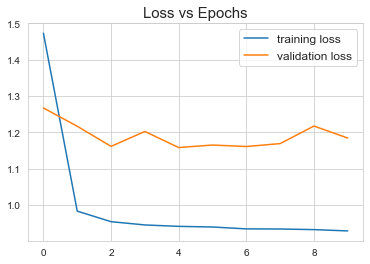

In [18]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

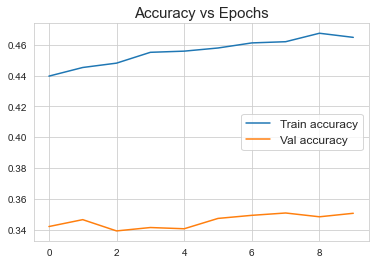

In [19]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [20]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,6267,2336
actual 1,0,5989,3062
actual 2,0,5467,3258


In [21]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3379224736218473

In [22]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3763863216266174

In [23]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3505439933280261

In [24]:
rnn_proba = model.predict_proba(test_sequence)

Instructions for updating:
Please use `model.predict()` instead.


In [25]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.102528,0.445293,0.452179
1,0.082579,0.456664,0.460757
2,0.100798,0.439834,0.459367
3,0.084552,0.446286,0.469162
4,0.077547,0.454286,0.468166


In [26]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [27]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 17:00:00,17,1,2,0,0.102528,0.445293,0.452179
2015-10-01 18:00:00,18,1,2,0,0.082579,0.456664,0.460757
2015-10-01 19:00:00,19,1,2,0,0.100798,0.439834,0.459367
2015-10-01 20:00:00,20,1,2,0,0.084552,0.446286,0.469162
2015-10-01 21:00:00,21,2,2,1,0.077547,0.454286,0.468166


In [28]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 23:00:00,23,1,1,1,0.096323,0.453057,0.450620
2015-10-02 09:00:00,9,2,1,0,0.146410,0.464882,0.388708
2015-10-02 10:00:00,10,2,1,0,0.256550,0.415966,0.327484
2015-10-02 11:00:00,11,2,1,0,0.123803,0.482935,0.393262
2015-10-02 12:00:00,12,1,1,1,0.161035,0.453791,0.385173


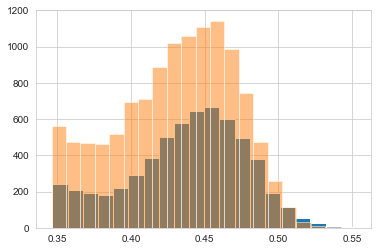

In [29]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [30]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 17:00:00,17,1,2,0,0.102528,0.445293,0.452179
2015-10-01 18:00:00,18,1,2,0,0.082579,0.456664,0.460757
2015-10-01 19:00:00,19,1,2,0,0.100798,0.439834,0.459367
2015-10-01 20:00:00,20,1,2,0,0.084552,0.446286,0.469162
2015-10-01 21:00:00,21,2,2,1,0.077547,0.454286,0.468166


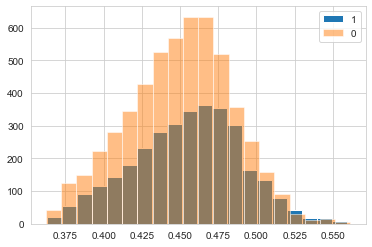

In [31]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 3</font>

In [32]:
# Create training sequences
series_length = 3
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [33]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [34]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [35]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [36]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 19s 62ms/step - loss: 1.6065 - categorical_accuracy: 0.4489 - val_loss: 1.3799 - val_categorical_accuracy: 0.3431
Epoch 2/50
310/310 [==============================] - 23s 73ms/step - loss: 1.0259 - categorical_accuracy: 0.4551 - val_loss: 1.2088 - val_categorical_accuracy: 0.3417
Epoch 3/50
310/310 [==============================] - 22s 72ms/step - loss: 0.9644 - categorical_accuracy: 0.4582 - val_loss: 1.2577 - val_categorical_accuracy: 0.3499
Epoch 4/50
310/310 [==============================] - 21s 68ms/step - loss: 0.9513 - categorical_accuracy: 0.4574 - val_loss: 1.1916 - val_categorical_accuracy: 0.3466
Epoch 5/50
310/310 [==============================] - 17s 56ms/step - loss: 0.9426 - categorical_accuracy: 0.4629 - val_loss: 1.1575 - val_categorical_accuracy: 0.3431
Epoch 6/50
310/310 [==============================] - 21s 68ms/step - loss: 0.9382 - categorical_accuracy: 0.4637 - val_loss: 1.2077 - val_categorical_accuracy:

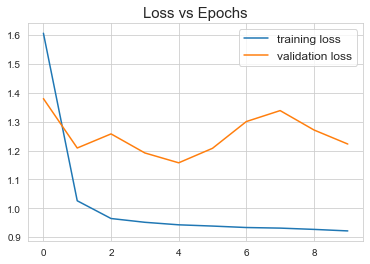

In [37]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

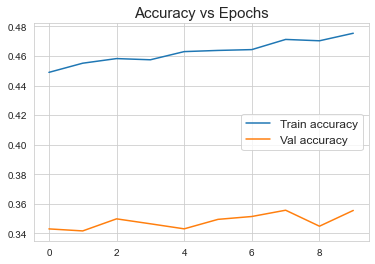

In [38]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [39]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,237,6578,1788
actual 1,126,6647,2276
actual 2,104,6126,2495


In [40]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34349646013125934

In [41]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3803933526452203

In [42]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3528367425704361

In [43]:
rnn_proba = model.predict_proba(test_sequence)

In [44]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.061115,0.460803,0.478082
1,0.064236,0.453550,0.482214
2,0.069828,0.453217,0.476955
3,0.069855,0.455768,0.474376
4,0.071060,0.459451,0.469489


In [45]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [46]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 19:00:00,19,1,2,0,0.061115,0.460803,0.478082
2015-10-01 20:00:00,20,1,2,0,0.064236,0.453550,0.482214
2015-10-01 21:00:00,21,2,2,1,0.069828,0.453217,0.476955
2015-10-01 22:00:00,22,1,2,0,0.069855,0.455768,0.474376
2015-10-01 23:00:00,23,1,2,0,0.071060,0.459451,0.469489


In [47]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 09:00:00,9,2,1,0,0.159042,0.429145,0.411813
2015-10-02 10:00:00,10,2,1,0,0.236776,0.413564,0.349660
2015-10-02 11:00:00,11,2,1,0,0.236927,0.433347,0.329726
2015-10-02 12:00:00,12,1,1,1,0.236760,0.426098,0.337141
2015-10-02 13:00:00,13,1,1,1,0.176670,0.463457,0.359874


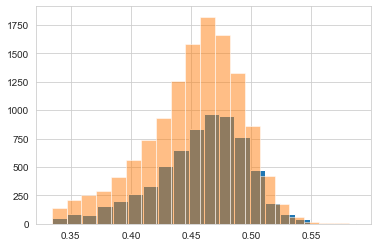

In [48]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [49]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 19:00:00,19,1,2,0,0.061115,0.460803,0.478082
2015-10-01 20:00:00,20,1,2,0,0.064236,0.453550,0.482214
2015-10-01 21:00:00,21,2,2,1,0.069828,0.453217,0.476955
2015-10-01 22:00:00,22,1,2,0,0.069855,0.455768,0.474376
2015-10-01 23:00:00,23,1,2,0,0.071060,0.459451,0.469489


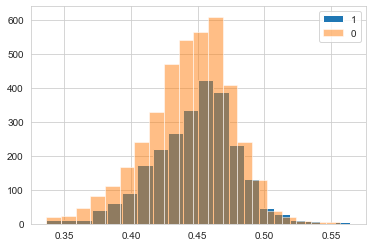

In [50]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 5</font>

In [51]:
# Create training sequences
series_length = 5
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [52]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [53]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [54]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [55]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 33s 105ms/step - loss: 1.6059 - categorical_accuracy: 0.4408 - val_loss: 1.3274 - val_categorical_accuracy: 0.3486
Epoch 2/50
310/310 [==============================] - 22s 71ms/step - loss: 1.0315 - categorical_accuracy: 0.4573 - val_loss: 1.3184 - val_categorical_accuracy: 0.3413
Epoch 3/50
310/310 [==============================] - 21s 67ms/step - loss: 0.9642 - categorical_accuracy: 0.4586 - val_loss: 1.1408 - val_categorical_accuracy: 0.3416
Epoch 4/50
310/310 [==============================] - 21s 68ms/step - loss: 0.9499 - categorical_accuracy: 0.4556 - val_loss: 1.1847 - val_categorical_accuracy: 0.3459
Epoch 5/50
310/310 [==============================] - 20s 66ms/step - loss: 0.9428 - categorical_accuracy: 0.4564 - val_loss: 1.1927 - val_categorical_accuracy: 0.3429
Epoch 6/50
310/310 [==============================] - 20s 65ms/step - loss: 0.9361 - categorical_accuracy: 0.4596 - val_loss: 1.2208 - val_categorical_accuracy

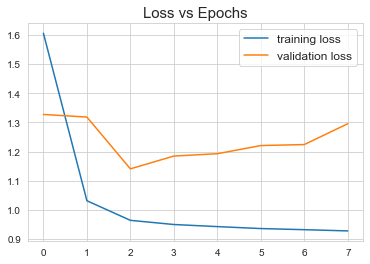

In [56]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

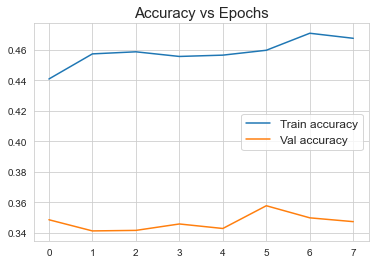

In [57]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [58]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,6072,2531
actual 1,0,5796,3251
actual 2,6,5353,3366


In [59]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3365658208001858

In [60]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.36794927853082643

In [61]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3474534491258675

In [62]:
rnn_proba = model.predict_proba(test_sequence)

In [63]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.062497,0.453111,0.484392
1,0.059181,0.458694,0.482125
2,0.059123,0.460174,0.480703
3,0.051120,0.464991,0.483888
4,0.049416,0.464290,0.486294


In [64]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [65]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 21:00:00,21,2,2,1,0.062497,0.453111,0.484392
2015-10-01 22:00:00,22,1,2,0,0.059181,0.458694,0.482125
2015-10-01 23:00:00,23,1,2,0,0.059123,0.460174,0.480703
2015-10-02 00:00:00,0,1,2,0,0.051120,0.464991,0.483888
2015-10-02 01:00:00,1,1,2,0,0.049416,0.464290,0.486294


In [66]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 09:00:00,9,2,1,0,0.103381,0.449371,0.447249
2015-10-02 10:00:00,10,2,1,0,0.198316,0.409997,0.391687
2015-10-02 11:00:00,11,2,1,0,0.224122,0.405694,0.370184
2015-10-02 12:00:00,12,1,1,1,0.208847,0.417634,0.373519
2015-10-02 13:00:00,13,1,1,1,0.139781,0.458529,0.401690


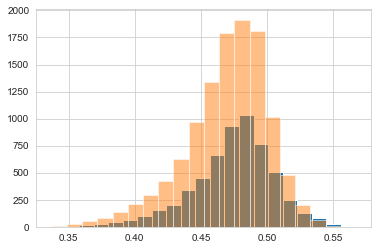

In [67]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [68]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 21:00:00,21,2,2,1,0.062497,0.453111,0.484392
2015-10-01 22:00:00,22,1,2,0,0.059181,0.458694,0.482125
2015-10-01 23:00:00,23,1,2,0,0.059123,0.460174,0.480703
2015-10-02 00:00:00,0,1,2,0,0.051120,0.464991,0.483888
2015-10-02 01:00:00,1,1,2,0,0.049416,0.464290,0.486294


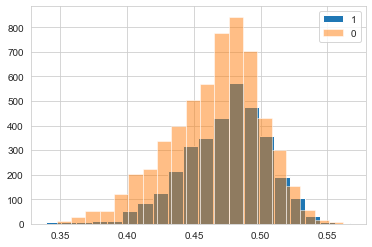

In [69]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

## <font color=green>Training sequence = 7</font>

In [70]:
# Create training sequences
series_length = 7
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [71]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [72]:
# Construct RNN with L2 regularization
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [73]:
# compile neural networkds with early stopping
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [74]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 27s 86ms/step - loss: 1.6656 - categorical_accuracy: 0.4453 - val_loss: 1.4192 - val_categorical_accuracy: 0.3392
Epoch 2/50
310/310 [==============================] - 26s 84ms/step - loss: 1.0553 - categorical_accuracy: 0.4502 - val_loss: 1.2648 - val_categorical_accuracy: 0.3494
Epoch 3/50
310/310 [==============================] - 26s 85ms/step - loss: 0.9707 - categorical_accuracy: 0.4549 - val_loss: 1.2500 - val_categorical_accuracy: 0.3449
Epoch 4/50
310/310 [==============================] - 27s 86ms/step - loss: 0.9501 - categorical_accuracy: 0.4611 - val_loss: 1.1536 - val_categorical_accuracy: 0.3603
Epoch 5/50
310/310 [==============================] - 26s 85ms/step - loss: 0.9416 - categorical_accuracy: 0.4581 - val_loss: 1.1561 - val_categorical_accuracy: 0.3562
Epoch 6/50
310/310 [==============================] - 27s 86ms/step - loss: 0.9369 - categorical_accuracy: 0.4653 - val_loss: 1.3287 - val_categorical_accuracy:

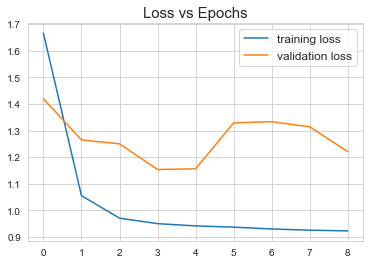

In [75]:
# plot loss curves
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.title("Loss vs Epochs", fontsize=15)
plt.legend(fontsize=12);

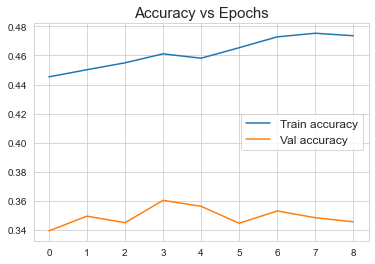

In [76]:
# plot accuracy vs epochs
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')

plt.title("Accuracy vs Epochs", fontsize=15)
plt.legend(fontsize=12);

In [77]:
# confusion matrix
# 0: No Profitable Trade
# 1: Profitable Long/Buy Trade
# 2: Profitable Short/Sell Trade

rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,0,8006,597
actual 1,0,8097,949
actual 2,10,7699,1015


In [78]:
# pred 1 specific precision score
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3401814973531636

In [79]:
# pred 2 specific precision score
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.396329558766107

In [80]:
# pred 1 & 2 specific precision score
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.34563592914311725

In [81]:
rnn_proba = model.predict_proba(test_sequence)

In [82]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.087399,0.511308,0.401293
1,0.077130,0.505010,0.417859
2,0.072785,0.503622,0.423593
3,0.068343,0.506007,0.425650
4,0.063990,0.501378,0.434633


In [83]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [84]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 23:00:00,23,1,1,1,0.087399,0.511308,0.401293
2015-10-02 00:00:00,0,1,1,1,0.077130,0.505010,0.417859
2015-10-02 01:00:00,1,1,1,1,0.072785,0.503622,0.423593
2015-10-02 02:00:00,2,1,1,1,0.068343,0.506007,0.425650
2015-10-02 03:00:00,3,1,1,1,0.063990,0.501378,0.434633


In [85]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 23:00:00,23,1,1,1,0.087399,0.511308,0.401293
2015-10-02 00:00:00,0,1,1,1,0.077130,0.505010,0.417859
2015-10-02 01:00:00,1,1,1,1,0.072785,0.503622,0.423593
2015-10-02 02:00:00,2,1,1,1,0.068343,0.506007,0.425650
2015-10-02 03:00:00,3,1,1,1,0.063990,0.501378,0.434633


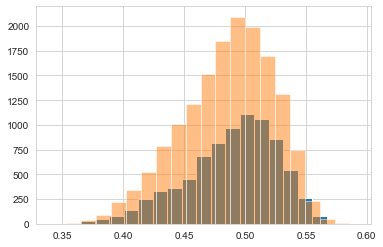

In [86]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [87]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 06:00:00,6,1,2,0,0.088565,0.454007,0.457428
2015-10-02 08:00:00,8,2,2,1,0.132507,0.431501,0.435992
2015-10-05 14:00:00,14,1,2,0,0.085977,0.436828,0.477195
2015-10-05 15:00:00,15,1,2,0,0.098570,0.424657,0.476773
2015-10-05 16:00:00,16,1,2,0,0.111534,0.424590,0.463876


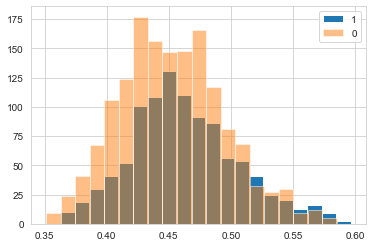

In [88]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()